In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import time

In [2]:
# S&P500 종목 리스트 크롤링
print("S&P500 종목 리스트 가져오는 중...")
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(url)
sp500_df = sp500_table[0]
sp500_df = sp500_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
sp500_df.columns = ['Ticker', 'Name', 'Sector', 'Subsector']

# 시가총액 가져오는 함수 정의
def get_market_cap(ticker):
    try:
        stock = yf.Ticker(ticker)
        market_cap = stock.info.get('marketCap', None)
        return market_cap
    except:
        return None

# 전체 종목에 대해 시가총액 가져오기
print("시가총액 데이터 가져오는 중...(시간 약간 걸려요)")
market_caps = []
for ticker in list(sp500_df['Ticker']) + ["EWJ", "EWY", "FXI", "FEZ", "GLD", "GSG", "SLV", "TLT", "SHY", "BIL"]:
    market_cap = get_market_cap(ticker)
    market_caps.append(market_cap)
    time.sleep(0.5)  # 과부하 방지 위해 0.5초 쉬기


tickers = ["SPY", "EWJ", "EWY", "FXI", "FEZ", "GLD", "GSG", "SLV", "TLT", "SHY", "BIL"]
names = ["S&P500 Index", "iShares MSCI Japan ETF", "MSCI South Korea Cap ETF", "iShares China Large-Cap ETF", "SPDR Euro Stoxx 50 ETF", "SPDR Gold Trust"
        , "iShares S&P GSCI Commodity-Indexed Trust ETF", "iShares Silver Trust", "iShares 20+ Year Treasury Bond ETF"
        , "Vanguard Total Bond Market Index Fund ETF", "iShares 0-3 Month Treasury Bond ETF"]
sectors = ["Index", "Foreign Market Index", "Foreign Market Index", "Foreign Market Index", "Foreign Market Index"
           , "Commodity Index", "Commodity Index", "Commodity Index"
           , "Bond", "Bond", "Bond"]
subsectors = ["Index", "Japan", "Korea", "China", "Euro-zone", "Gold", "Composite Commodity", "Silver"
             , "Long-term Bond", "Composite Bond", "Short-term Bond"]

for ticker, name, sector, subsector in zip(tickers, names, sectors, subsectors):
    sp500_df.loc[len(sp500_df)] = ([ticker, name, sector, subsector])


sp500_df['MarketCap'] = market_caps
sp500_df.to_csv('sp500.csv', index=False)

S&P500 종목 리스트 가져오는 중...
시가총액 데이터 가져오는 중...(시간 약간 걸려요)


C:\Users\chlwl\AppData\Local\Temp\ipykernel_36920\2517706703.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df.loc[len(sp500_df)] = ([ticker, name, sector, subsector])
C:\Users\chlwl\AppData\Local\Temp\ipykernel_36920\2517706703.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df.loc[len(sp500_df)] = ([ticker, name, sector, subsector])
C:\Users\chlwl\AppData\Local\Temp\ipykernel_36920\2517706703.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

ValueError: Length of values (513) does not match length of index (514)

In [15]:
sp500_df = pd.read_csv('sp500.csv')
sp500_df

,Ticker,Name,Sector,Subsector,MarketCap
0,MMM,3M,Industrials,Industrial Conglomerates,7.577588e+10
1,AOS,A. O. Smith,Industrials,Building Products,9.711699e+09
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,2.315030e+11
3,ABBV,AbbVie,Health Care,Biotechnology,3.468430e+11
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,1.926340e+11
...,...,...,...,...,...
508,GSG,iShares S&P GSCI Commodity-Indexed Trust ETF,Commodity Index,Composite Commodity,1.318554e+09
509,SLV,iShares Silver Trust,Commodity Index,Silver,1.031862e+10
510,TLT,iShares 20+ Year Treasury Bond ETF,Bond,Long-term Bond,9.602041e+09
511,SHY,Vanguard Total Bond Market Index Fund ETF,Bond,Composite Bond,1.728609e+10


In [3]:
tickers = sp500_df['Ticker'].tolist()

batch_size = 50
prices_5yr = []
count = 0

print("📥 데이터 다운로드 시작...")

for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i + batch_size]
    print(f"\n📦 Batch {i // batch_size + 1}: Downloading {len(batch)} tickers")

    try:
        data = yf.download(batch, start="2020-04-25", end="2025-04-24",
                           auto_adjust=False, progress=False)['Adj Close']
        
        if isinstance(data, pd.Series):  # 단일 종목만 리턴된 경우 처리
            data = data.to_frame()

        for ticker in batch:
            if ticker in data.columns:
                price = data[[ticker]]
                prices_5yr.append(price)
                count += 1
                print(f"✅ {ticker} 완료 ({count}/{len(tickers)})")
            else:
                print(f"⚠️ {ticker} → 데이터 없음")

    except Exception as e:
        print(f"⛔️ Error in batch {i // batch_size + 1}: {e}")

    print("⏳ 10초 대기 중...")
    time.sleep(10)


📥 데이터 다운로드 시작...

📦 Batch 1: Downloading 1 tickers
✅ SPY 완료 (1/1)
⏳ 10초 대기 중...


In [ ]:
return_df = pd.concat(prices_5yr, axis=1)
return_df.to_csv('out/return_df.csv')

In [19]:
return_df = pd.read_csv('return_df.csv')
return_df

,Unnamed: 0,Date,SPY,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,...,EWJ,EWY,FXI,FEZ,GLD,GSG,SLV,TLT,SHY,BIL
0,0,2020-04-27,266.893097,105.391487,38.672676,86.898926,69.004913,166.581940,348.500000,56.490002,...,47.253185,46.768921,34.834816,26.481773,161.559998,7.960000,14.210000,146.178070,78.169693,80.659081
1,1,2020-04-28,265.665802,108.107719,39.427395,83.704887,67.432358,165.588562,333.450012,55.509998,...,47.940140,46.832890,34.870583,26.629566,160.839996,7.930000,14.100000,147.860825,78.196762,80.659081
2,2,2020-04-29,272.620514,107.181747,40.286900,84.455330,68.247139,174.129791,349.170013,53.660000,...,48.782799,48.139641,35.433872,27.551130,161.729996,8.140000,14.280000,147.093567,78.187752,80.650284
3,3,2020-04-30,270.082275,104.204834,38.750774,84.281441,66.976067,171.929489,353.640015,52.389999,...,47.408890,47.171001,34.503990,27.012098,158.800003,8.480000,13.980000,145.375977,78.323112,80.667885
4,4,2020-05-01,262.932251,101.927582,38.083286,82.231377,67.497528,167.194687,343.839996,49.880001,...,46.575390,45.544415,33.323757,26.412222,159.779999,8.480000,13.920000,146.620926,78.207512,80.653786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,1250,2025-04-16,525.659973,130.460007,62.541103,129.699997,171.679993,285.239990,344.190002,88.290001,...,66.779999,54.060001,32.419998,53.299999,307.470001,21.360001,29.760000,87.986252,82.462250,91.278442
1251,1251,2025-04-17,526.409973,130.210007,62.819683,130.979996,172.990005,282.350006,348.799988,87.500000,...,68.070000,54.310001,32.400002,53.770000,306.119995,21.590000,29.549999,87.209106,82.492157,91.318306
1252,1252,2025-04-21,513.880005,126.089996,61.396935,129.889999,170.160004,279.230011,343.220001,85.559998,...,67.919998,54.389999,32.430000,53.130001,315.589996,21.410000,29.790001,85.684723,82.442307,91.328270
1253,1253,2025-04-22,527.250000,136.330002,63.635521,131.729996,173.779999,283.959992,349.910004,86.260002,...,69.269997,54.810001,33.459999,54.580002,311.109985,21.559999,29.500000,86.162964,82.472221,91.328270


# 종목 선정

In [23]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant

# 데이터 로드
returns_df = pd.read_csv("return_df.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
info_df = pd.read_csv("sp500.csv")

# 티커 목록 정제
tickers = [col for col in returns_df.columns if col != "date"]
snp500_tickers = list(set(tickers) & set(info_df['Ticker']))
snp500_tickers = sorted(snp500_tickers)[:-10]  # 마지막 10개 제외

# 섹터별 시가총액 비례 계산
info_filtered = info_df[info_df['Ticker'].isin(snp500_tickers)].copy()
sector_weights = info_filtered.groupby("Sector")["MarketCap"].sum()
sector_counts = ((sector_weights / sector_weights.sum()) * 40).round().astype(int)

# 합계가 40이 안 맞을 경우 조정
while sector_counts.sum() != 40:
    diff = 40 - sector_counts.sum()
    target = sector_counts.idxmax() if diff < 0 else sector_counts.idxmin()
    sector_counts[target] += np.sign(diff)

# 수익률 계산
returns_df.set_index("date", inplace=True)
returns_df.drop('Unnamed: 0', axis=1, inplace=True)
returns_df = returns_df.dropna(axis=1, how='all')
returns_df = returns_df.ffill(axis=1)
returns = returns_df.pct_change().dropna()

# 시장 수익률 (SPY 사용)
market = returns["SPY"]

# 무위험 수익률 예시 (수정 가능): 연 4% 고정 → 일간 수익률
rf_daily = 0.04 / 252
rf = pd.Series(rf_daily, index=returns.index)

# 결과 저장
result_list = []

for ticker in snp500_tickers:

    if ticker in ['GOOG', 'NWSA']:
        continue
    
    try:
        stock = returns[ticker].dropna()
        aligned = pd.concat([stock, market, rf], axis=1, join="inner").dropna()
        if len(aligned) < 200:
            continue  # 데이터 너무 적으면 제외
        r_i = aligned[ticker]
        r_m = aligned["SPY"]
    
        excess_m = r_m - aligned[0]
        excess_m.name = "excess_market"
        excess_i = r_i - aligned[0]
        
        X = add_constant(excess_m)
        model = OLS(excess_i, X).fit()
        alpha = model.params["const"]
        beta = model.params["excess_market"]
    
        X = add_constant(excess_m)
        model = OLS(excess_i, X).fit()
        alpha = model.params["const"]
        beta = model.params[excess_m.name]
        r_squared = model.rsquared
        volatility = r_i.std() * np.sqrt(252)  # 연율화
    
        result_list.append({
            "Ticker": ticker,
            "Alpha": alpha,
            "Beta": beta,
            "R2": r_squared,
            "Volatility": volatility,
        })
    except KeyError:
        continue
    
result_df = pd.DataFrame(result_list)
merged = result_df.merge(info_df, on="Ticker")
    

In [25]:
merged

,Ticker,Alpha,Beta,R2,Volatility,Name,Sector,Subsector,MarketCap
0,A,-0.000174,0.977547,0.400973,0.278060,Agilent Technologies,Health Care,Life Sciences Tools & Services,3.089657e+10
1,AAPL,0.000310,1.254146,0.569871,0.299239,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",2.970580e+12
2,ABBV,0.000519,0.383344,0.093230,0.226136,AbbVie,Health Care,Biotechnology,3.468430e+11
3,ABNB,-0.000686,1.418391,0.253724,0.507194,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",7.708366e+10
4,ABT,-0.000011,0.599269,0.224041,0.228043,Abbott Laboratories,Health Care,Health Care Equipment,2.315030e+11
...,...,...,...,...,...,...,...,...,...
494,WMB,0.000792,0.711301,0.235339,0.264098,Williams Companies,Energy,Oil & Gas Storage & Transportation,7.344896e+10
495,WMT,0.000414,0.456487,0.151807,0.211029,Walmart,Consumer Staples,Consumer Staples Merchandise Retail,7.947280e+11
496,WRB,0.000660,0.585865,0.176836,0.250940,W. R. Berkley Corporation,Financials,Property & Casualty Insurance,2.756401e+10
497,WSM,0.001019,1.253484,0.229073,0.471727,"Williams-Sonoma, Inc.",Consumer Discretionary,Homefurnishing Retail,1.947249e+10


In [27]:
# 필터링: R² 기준
filtered = merged[merged["R2"] >= 0.25].copy()

# 섹터별 종목 선정
final_selected = []

for sector, count in sector_counts.items():
    group = filtered[filtered["Sector"] == sector].copy()
    if group.empty:
        continue
    # 스코어 계산: 알파 높고, 변동성 낮고, 베타 1에 가까운 순
    group["Score"] = (
        group["MarketCap"].rank(ascending=False) * 0.4 +
        group["Alpha"].rank(ascending=False) * 0.3 +
        group["Volatility"].rank(ascending=True) * 0.2 +
        (group["Beta"] - 1).abs().rank(ascending=True) * 0.1
    )
    final_selected.extend(group.sort_values("Score").head(count)["Ticker"].tolist())

# 마지막 10개 ETF 또는 비대상 종목 추가
excluded_10 = tickers[-10:]

# 최종 선정 종목 리스트 (40 + 10 = 50개)
final_50 = final_selected + excluded_10

print("최종 선정된 50개 종목:")
print(final_50)

최종 선정된 50개 종목:
['GOOGL', 'NWS', 'META', 'CMCSA', 'LYV', 'DIS', 'TJX', 'BKNG', 'LOW', 'CMG', 'COST', 'MNST', 'EL', 'KMI', 'JPM', 'AJG', 'GS', 'MS', 'V', 'BSX', 'SYK', 'ISRG', 'TMO', 'CTAS', 'TT', 'GE', 'ORCL', 'MSFT', 'AAPL', 'AVGO', 'APH', 'ACN', 'MSI', 'CSCO', 'PANW', 'NVDA', 'INTU', 'LIN', 'VICI', 'AES', 'EWJ', 'EWY', 'FXI', 'FEZ', 'GLD', 'GSG', 'SLV', 'TLT', 'SHY', 'BIL']


In [29]:
len(final_50)

50

In [31]:
info_df[info_df['Ticker'].isin(final_50)].sort_values(['Sector', 'MarketCap'], ascending=True)

,Ticker,Name,Sector,Subsector,MarketCap
510,TLT,iShares 20+ Year Treasury Bond ETF,Bond,Long-term Bond,9.602041e+09
511,SHY,Vanguard Total Bond Market Index Fund ETF,Bond,Composite Bond,1.728609e+10
512,BIL,iShares 0-3 Month Treasury Bond ETF,Bond,Short-term Bond,NaN
508,GSG,iShares S&P GSCI Commodity-Indexed Trust ETF,Commodity Index,Composite Commodity,1.318554e+09
509,SLV,iShares Silver Trust,Commodity Index,Silver,1.031862e+10
507,GLD,SPDR Gold Trust,Commodity Index,Gold,8.211945e+10
336,NWS,News Corp (Class B),Communication Services,Publishing,1.651604e+10
290,LYV,Live Nation Entertainment,Communication Services,Movies & Entertainment,3.154873e+10
115,CMCSA,Comcast,Communication Services,Cable & Satellite,1.286260e+11
482,DIS,Walt Disney Company (The),Communication Services,Movies & Entertainment,1.666240e+11


# 시각화

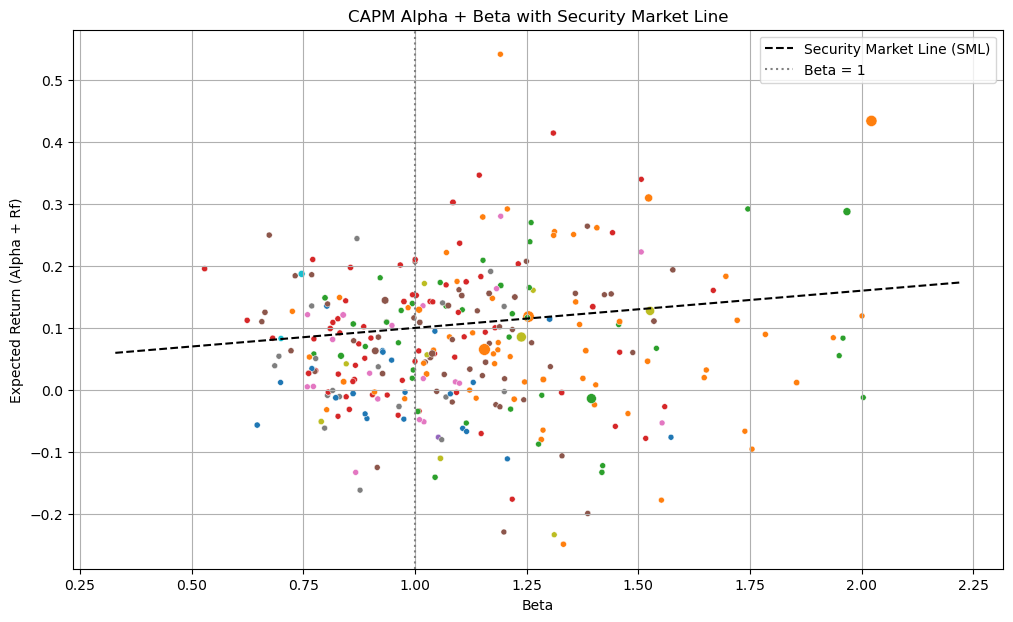

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 예시 파라미터 (수정 가능)
rf = 0.04  # 무위험 수익률
rm = 0.10  # 시장 기대 수익률

# SML 선 계산
min_beta = filtered["Beta"].min()
max_beta = filtered["Beta"].max()
beta_range = np.linspace(min_beta - 0.2, max_beta + 0.2, 100)
sml_y = rf + beta_range * (rm - rf)

# 종목의 기대 수익률 계산: alpha + rf
filtered["ExpectedReturn"] = filtered["Alpha"]*252 + rf

# 시각화
plt.figure(figsize=(12, 7))
# SML 선
plt.plot(beta_range, sml_y, label="Security Market Line (SML)", color='black', linestyle='--')
# 종목 점
sns.scatterplot(data=filtered, x="Beta", y="ExpectedReturn", hue="Sector", size="MarketCap", palette="tab10", legend=False)

# 시각 보조선
plt.axvline(1.0, color='gray', linestyle=':', label='Beta = 1')
plt.title("CAPM Alpha + Beta with Security Market Line")
plt.xlabel("Beta")
plt.ylabel("Expected Return (Alpha + Rf)")
plt.grid(True)
plt.legend()
plt.show()

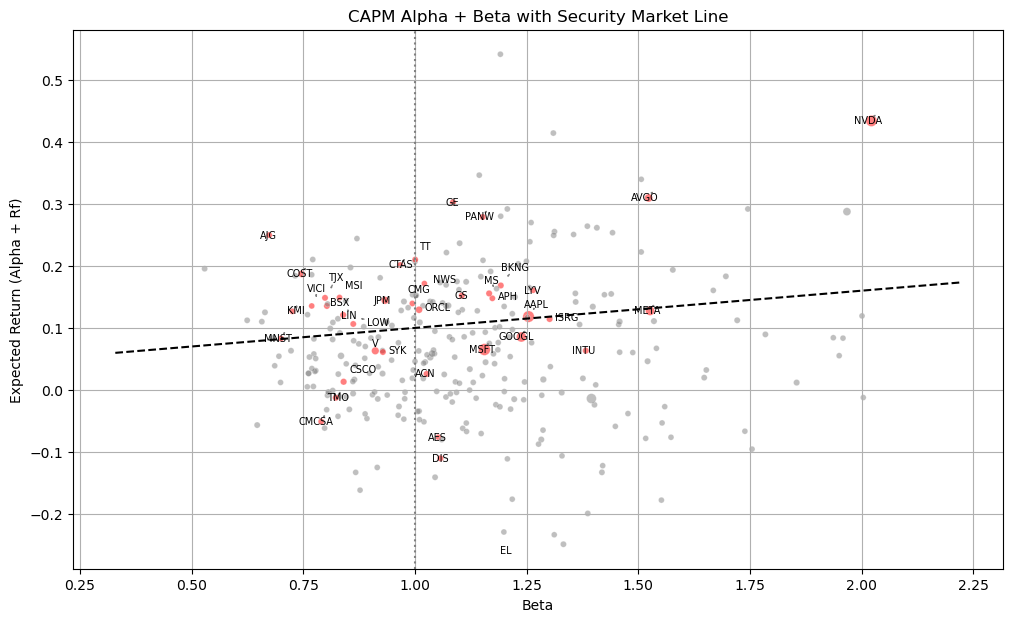

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text  # 텍스트 겹침 방지 라이브러리

# 예시 파라미터 (수정 가능)
rf = 0.04  # 무위험 수익률
rm = 0.10  # 시장 기대 수익률

# SML 선 계산
min_beta = filtered["Beta"].min()
max_beta = filtered["Beta"].max()
beta_range = np.linspace(min_beta - 0.2, max_beta + 0.2, 100)
sml_y = rf + beta_range * (rm - rf)

# 종목의 기대 수익률 계산: alpha + rf
filtered["ExpectedReturn"] = filtered["Alpha"]*252 + rf

# final_40 리스트 (컬러로 나타낼 종목)
final_40 = final_50[:-10]

# 종목을 색상으로 구분 (final_40에 포함된 종목은 컬러로, 나머지는 흑백으로)
filtered['color'] = filtered['Ticker'].apply(lambda x: 'red' if x in final_40 else 'gray')

# 시각화
plt.figure(figsize=(12, 7))

# SML 선
plt.plot(beta_range, sml_y, label="Security Market Line (SML)", color='black', linestyle='--')

# 종목 점 (색상 적용)
sns.scatterplot(data=filtered, x="Beta", y="ExpectedReturn", size="MarketCap", hue="color", palette={"red": "red", "gray": "gray"}, alpha=0.5, legend=False)

# final_40에 포함된 종목만 각 점에 ticker를 표시
texts = []  # 텍스트 객체를 저장할 리스트
for i in range(len(filtered)):
    ticker = filtered.iloc[i]['Ticker']
    if ticker in final_40:  # final 40에 있는 경우에만 텍스트 표시
        beta = filtered.iloc[i]['Beta']
        expected_return = filtered.iloc[i]['ExpectedReturn']
        text  = plt.text(beta+0.01, expected_return+0.01, ticker, fontsize=7, ha='center', va='center')
        texts.append(text)  # 텍스트 객체를 리스트에 추가

# 텍스트 겹침 방지
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray'))

# 시각 보조선
plt.axvline(1.0, color='gray', linestyle=':', label='Beta = 1')

# 그래프 제목 및 라벨
plt.title("CAPM Alpha + Beta with Security Market Line")
plt.xlabel("Beta")
plt.ylabel("Expected Return (Alpha + Rf)")
plt.grid(True)

# 범례
# plt.legend(title='Ticker', labels=final_40)

plt.show()

In [54]:
selected_price_data = return_df[['Date'] + final_50]
selected_price_data.to_csv('selected_price_data.csv', index=False)
selected_price_data

,Date,GOOGL,NWS,META,CMCSA,LYV,DIS,TJX,BKNG,LOW,...,EWJ,EWY,FXI,FEZ,GLD,GSG,SLV,TLT,SHY,BIL
0,2020-04-27,63.240650,9.157999,186.620468,33.521606,42.009998,104.765762,44.837585,1387.816895,93.280434,...,47.253185,46.768921,34.834816,26.481773,161.559998,7.960000,14.210000,146.178070,78.169693,80.659081
1,2020-04-28,61.336254,9.453727,182.051987,33.407558,43.639999,104.913933,46.009121,1423.753784,94.698326,...,47.940140,46.832890,34.870583,26.629566,160.839996,7.930000,14.100000,147.860825,78.196762,80.659081
2,2020-04-29,66.789688,10.312287,193.279068,34.214680,46.529999,110.880226,48.305367,1504.085571,97.113380,...,48.782799,48.139641,35.433872,27.551130,161.729996,8.140000,14.280000,147.093567,78.187752,80.650284
3,2020-04-30,67.014603,9.749452,203.749725,33.012775,44.869999,106.830261,45.971638,1464.557739,95.823540,...,47.408890,47.171001,34.503990,27.012098,158.800003,8.480000,13.980000,145.375977,78.323112,80.667885
4,2020-05-01,65.552597,9.253395,201.321167,32.442520,41.169998,104.212593,45.221844,1433.121460,95.558220,...,46.575390,45.544415,33.323757,26.412222,159.779999,8.480000,13.920000,146.620926,78.207512,80.653786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,2025-04-16,153.330002,29.750000,502.309998,33.549999,125.459999,82.769997,126.309998,4540.839844,213.284470,...,66.779999,54.060001,32.419998,53.299999,307.470001,21.360001,29.760000,87.986252,82.462250,91.278442
1251,2025-04-17,151.160004,30.000000,501.480011,34.009998,127.220001,84.809998,127.620003,4573.310059,217.850372,...,68.070000,54.310001,32.400002,53.770000,306.119995,21.590000,29.549999,87.209106,82.492157,91.318306
1252,2025-04-21,147.669998,29.450001,484.660004,33.599998,123.480003,84.000000,123.980003,4437.629883,211.653076,...,67.919998,54.389999,32.430000,53.130001,315.589996,21.410000,29.790001,85.684723,82.442307,91.328270
1253,2025-04-22,151.470001,30.290001,500.279999,34.200001,128.500000,86.089996,125.709999,4598.080078,217.920013,...,69.269997,54.810001,33.459999,54.580002,311.109985,21.559999,29.500000,86.162964,82.472221,91.328270


In [56]:
selected_meta_data = info_df[info_df['Ticker'].isin(final_50)]
selected_meta_data.to_csv('selected_meta_data.csv', index=False)
selected_meta_data

,Ticker,Name,Sector,Subsector,MarketCap
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,1.926340e+11
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,7.432476e+09
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,2.002690e+12
33,APH,Amphenol,Information Technology,Electronic Components,9.714895e+10
39,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",2.970580e+12
45,AJG,Arthur J. Gallagher & Co.,Financials,Insurance Brokers,8.661504e+10
68,BKNG,Booking Holdings,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",1.689210e+11
69,BSX,Boston Scientific,Health Care,Health Care Equipment,1.542170e+11
71,AVGO,Broadcom,Information Technology,Semiconductors,9.437740e+11
100,CMG,Chipotle Mexican Grill,Consumer Discretionary,Restaurants,6.785305e+10
